# Fraud Detection

### Постановка проблемы
Определение и анализ мошеннических транзакций имеют огромную актуальность в современном обществе, особенно в свете увеличения объёма онлайн-транзакций и электронной коммерции. В наше время мошенники все чаще используют новые и совершенные методы атак, чтобы обмануть людей и организации. Поэтому установление и анализ фактов мошенничества становится важным элементом для защиты финансовых интересов и обеспечения безопасности.  

### Данные
В связи с высоким уровнем конфиденциальности и "приватности" финансовых данных, существуют определенные трудности в их получении для анализа. Именно поэтому в рамках данного анализа было решено использовать синтетический набор данных, который был сгенерирован с помощью *PaySim* (https://github.com/EdgarLopezPhD/PaySim). Представленный датасет симулирован с использованием реальных показателей и статистики, собранных одной из крупных транснациональных компаний, предоставляющей финансовые услуги.  

**Ссылка на датасет**: https://www.kaggle.com/datasets/ealaxi/paysim1  

Всего в датасете представлено **6362620 транзакций**.  
В датасете также представлена информация о следующих свойствах транзакций:
- Временной шаг (момент времени, в который была выполнена транзакция, выражается в часах) - step
- Тип транзакции - type
- Сумма перевода - amount
- ID отправителя - nameOrig
- ID получателя - nameDest
- Сумма счета **отправителя** до и после выполнения транзакции - oldbalanceOrg и newbalanceOrig
- Сумма счета **получателя** до и после выполнения транзакции - oldbalanceDest и newbalanceDest
- Пометка, является ли транзакция мошеннической - isFraud  

### Этапы работы
1. **General Overview** - предварительный обзор данных
2. **EDA** - разведочный анализ данных для выявления закономерностей и взаимосвязей между признаками
3. **Data Preprocessing** - подготовка данных
4. **Model Building** - выбор и обучение ML-модели
5. **Model Performance** - оценка эффективности и точности работы обученной модели

## General Overview

Подключение необходимых библиотек.

In [31]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(palette="pastel")
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import sklearn.metrics
import sklearn.model_selection
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score, roc_curve, average_precision_score)

from xgboost import XGBClassifier, plot_importance

import warnings
warnings.filterwarnings("ignore")

Загрузка и предварительный просмотр датасета.

In [1]:
df = pd.read_csv('../data/fraud_dataset.csv')
df.drop("isFlaggedFraud", axis=1, inplace=True)
df.drop_duplicates(inplace=True)
df.head(100)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.00,0.00,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.00,0.00,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.00,0.00,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.00,0.00,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...
95,1,TRANSFER,710544.77,C835773569,0.0,0.00,C1359044626,738531.50,16518.36,0
96,1,TRANSFER,581294.26,C843299092,0.0,0.00,C1590550415,5195482.15,19169204.93,0
97,1,TRANSFER,11996.58,C605982374,0.0,0.00,C1225616405,40255.00,0.00,0
98,1,PAYMENT,2875.10,C1412322831,15443.0,12567.90,M1651262695,0.00,0.00,0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 485.4+ MB


Проверка на наличие пустых (NA) значений.

In [3]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

### Описательная статистика  

1. Для *числовых* значений:

In [4]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00


2. Для *категориальных* значений:

In [5]:
df.describe(include="object")

,type,nameOrig,nameDest
count,6362620,6362620,6362620
unique,5,6353307,2722362
top,CASH_OUT,C1902386530,C1286084959
freq,2237500,3,113


Подсчёт количества мошеннических и легитимных транзакций.

In [6]:
isFraud_counts = df["isFraud"].value_counts().values
print(f'Число легитимных транзакций: {isFraud_counts[0]}\nЧисло мошеннических транзакций: {isFraud_counts[1]}')
print(f'Соотношение (в %): {isFraud_counts[0] / sum(isFraud_counts)* 100:.2f} / {isFraud_counts[1] / sum(isFraud_counts) * 100:.2f}')

Число легитимных транзакций: 6354407
Число мошеннических транзакций: 8213
Соотношение (в %): 99.87 / 0.13


Получилось, что мошеннические транзакции составляют всего лишь **0,13%** от общего числа.  

Это говорит о том, что в датасете имеет место __*дисбаланс*__ классов.

## Exploratory Data Analysis (EDA)

Распределение типов транзакций по типам.

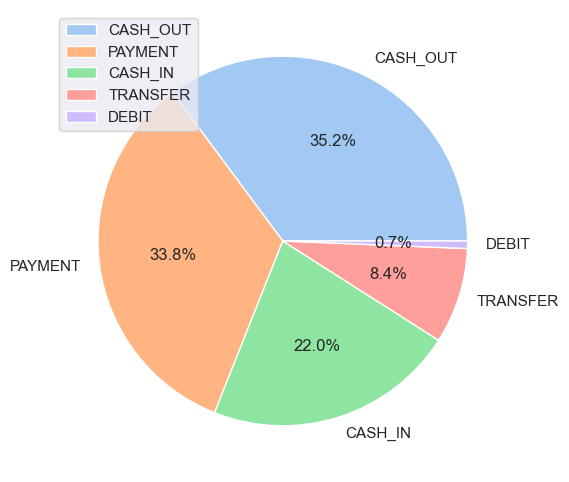

In [7]:
types = df["type"].value_counts()
tx_types = types.index.tolist()
tx_counts = types.values.tolist()

plt.figure(figsize=(6, 6))
plt.pie(tx_counts, labels=tx_types, autopct="%1.1f%%")
plt.legend(loc="upper left")
plt.show()

Распределение по типам мошеннических и легитимных транзакций.

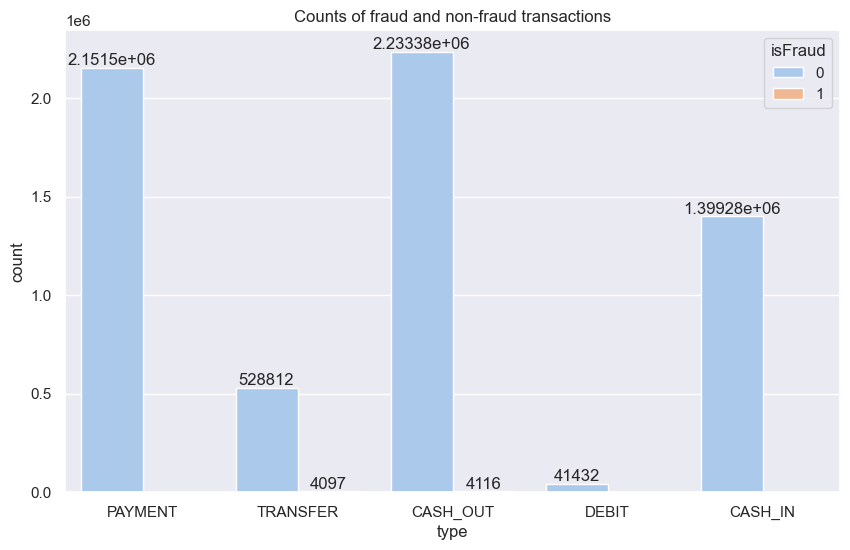

In [8]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="type", hue="isFraud", data=df)
ax.set_title("Counts of fraud and non-fraud transactions")
for label in ax.containers:
    ax.bar_label(label)

Как видно из графика, мошеннические транзакции бывают только среди двух типов: **TRANSFER** и **CASH_OUT**, то есть для операций перевода и снятия денежных средств со счёта.

In [9]:
df[['nameOrig', 'nameDest', 'isFraud']]

,nameOrig,nameDest,isFraud
0,C1231006815,M1979787155,0
1,C1666544295,M2044282225,0
2,C1305486145,C553264065,1
3,C840083671,C38997010,1
4,C2048537720,M1230701703,0
...,...,...,...
6362615,C786484425,C776919290,1
6362616,C1529008245,C1881841831,1
6362617,C1162922333,C1365125890,1
6362618,C1685995037,C2080388513,1


In [10]:
df.nameOrig.str[0].unique().tolist()

['C']

In [11]:
df.nameDest.str[0].unique().tolist()

['M', 'C']

Здесь можем увидеть, что существует один тип аккаунта отправителя (C = Customer) и два типа для аккаунта получателя (C = Customer, M = Merchant).  
Соответственно, можем выделить новый признак, который будет учитывать тип операции по типам аккаунтов отправителя и получателя.  
Возможны следующие комбинации: CM, CC.

In [12]:
df_new = df.copy()
df_new["type2"] = df_new.nameOrig.str[0] + df_new.nameDest.str[0]
df_new["type2"]

0          CM
1          CM
2          CC
3          CC
4          CM
           ..
6362615    CC
6362616    CC
6362617    CC
6362618    CC
6362619    CC
Name: type2, Length: 6362620, dtype: object

In [13]:
fraud = df_new[df_new['isFraud'] == 1]
valid = df_new[df_new['isFraud'] == 0]

Количество мошеннических и легитимных транзакций по признаку **type2**:

In [14]:
print("Fraud transactions by type2: \n", fraud.type2.value_counts())
print("\n Valid transactions by type2: \n", valid.type2.value_counts())

Fraud transactions by type2: 
 type2
CC    8213
Name: count, dtype: int64

 Valid transactions by type2: 
 type2
CC    4202912
CM    2151495
Name: count, dtype: int64


Также стоит обратить внимание на распределение количества транзакций (мошеннических и легитимных) по времени (признак **step**):

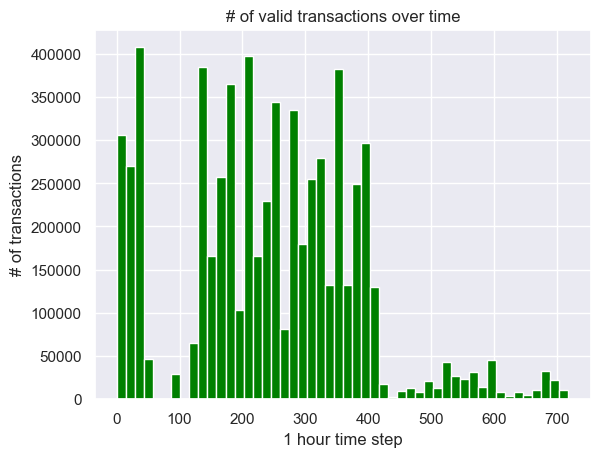

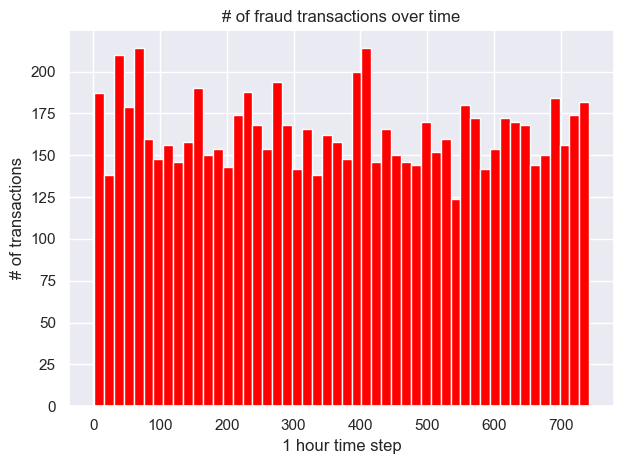

In [15]:
bins = 50

valid.hist(column="step",color="green",bins=bins)
plt.xlabel("1 hour time step")
plt.ylabel("# of transactions")
plt.title("# of valid transactions over time")

fraud.hist(column ="step",color="red",bins=bins)
plt.xlabel("1 hour time step")
plt.ylabel("# of transactions")
plt.title("# of fraud transactions over time")

plt.tight_layout()
plt.show()

Как видно из диаграмм, распределение числа легитимных транзакций **смещено влево**, в то время как мошеннические транзакции распределены **равномерно** по всему диапазону времени.

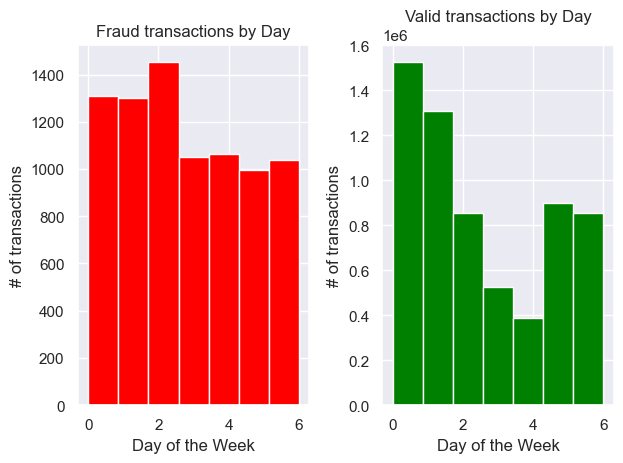

In [16]:
num_days = 7
num_hours = 24

fraud_days = (fraud.step//num_hours) % num_days
valid_days = (valid.step//num_hours) % num_days

plt.subplot(1, 2, 1)
fraud_days.hist(bins=num_days,color="red")
plt.title('Fraud transactions by Day')
plt.xlabel('Day of the Week')
plt.ylabel("# of transactions")

plt.subplot(1,2,2)
valid_days.hist(bins=num_days,color="green")
plt.title('Valid transactions by Day')
plt.xlabel('Day of the Week')
plt.ylabel("# of transactions")

plt.tight_layout()
plt.show()

В распределении числа транзакций по дням недели также наблюдается неравномерсть (для легитимных транзакций).

## Data Preprocessing

Избавимся от нерелевантных для построения модели признаков, в частности: **nameOrig**, **nameDest**, **oldbalanceOrg**, **newbalanceOrig**, **oldBalanceDest**, **newbalanceDest**.

In [17]:
df_new = df_new.drop(["nameOrig", "nameDest"], axis=1)

Также необходимо закодировать категориальные признаки (type, type2).

In [18]:
ohe = OneHotEncoder(sparse=False)
df_encoded = pd.DataFrame(ohe.fit_transform(df_new[["type", "type2"]]))
df_encoded.columns = ohe.get_feature_names_out()

df_new = df_new.join(df_encoded)
df_new.drop(columns=["type", "type2"], axis=1, inplace=True)

In [19]:
df_new.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CC,type2_CM
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1,181.00,181.0,0.00,0.0,0.0,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,1,181.00,181.0,0.00,21182.0,0.0,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


Разделим датасет на обучающую и тестовую выборки. А также нормализуем значения, приведя их к одному масштабу с помощью **MinMaxScaler**.

In [20]:
X = df_new.drop("isFraud", axis = 1)
Y = df_new.isFraud
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)
    
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

Здесь мы используем библиотеку imbalanced-learn для уменьшения выборки с помощью **RandomUnderSampler**.  
Этот метод случайным образом удаляет примеры из класса-большинства до достижения баланса.

In [21]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy = 0.2)
X_res, Y_res = rus.fit_resample(X_train, Y_train)

## Model Building

Функция для построения графика ROC-кривой.

In [28]:
def plot_roc_auc(Y_pred_proba, Y_test, model_name):
    fpr, tpr, _ = roc_curve(Y_test, Y_pred_proba)
    auc = roc_auc_score(Y_test, Y_pred_proba)
    plt.plot(fpr, tpr, label=f"{model_name}, AUC = {str(auc)}")
    plt.legend(loc=4)
    plt.show()

### Logistic Regression

In [57]:
from sklearn.linear_model import LogisticRegression

In [59]:
lrmodel = LogisticRegression()
lrmodel.fit(X_res, Y_res)

In [69]:
Y_pred = lrmodel.predict(X_test)
Y_predtrain = lrmodel.predict(X_train)
lr_auprc = average_precision_score(Y_test, Y_pred)
print("The Area Under Precision Recall Curve is ", lr_auprc)
print(classification_report(Y_test, Y_pred))

The Area Under Precision Recall Curve is  0.012687610217383637
              precision    recall  f1-score   support

           0       1.00      0.97      0.99   1588610
           1       0.02      0.50      0.05      2045

    accuracy                           0.97   1590655
   macro avg       0.51      0.74      0.52   1590655
weighted avg       1.00      0.97      0.99   1590655



<Axes: >

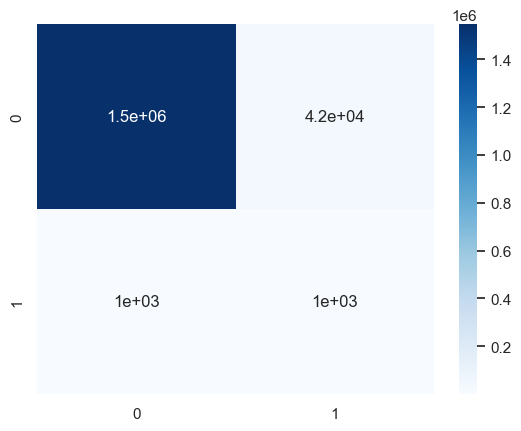

In [62]:
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, cmap="Blues")

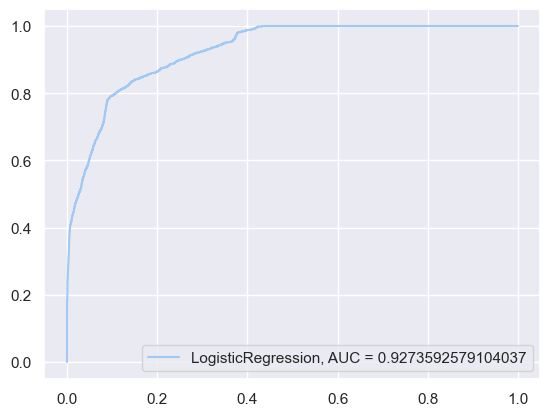

In [63]:
Y_pred_proba = lrmodel.predict_proba(X_test)[::,1]
plot_roc_auc(Y_pred_proba, Y_test, "LogisticRegression")

### XGBoost

In [22]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

xgbmodel = XGBClassifier()
xgbmodel.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [70]:
Y_pred = xgbmodel.predict(X_test)
xgb_auprc = average_precision_score(Y_test, Y_pred)
print("The Area Under Precision Recall Curve is ", xgb_auprc)
print(classification_report(Y_test, Y_pred))

The Area Under Precision Recall Curve is  0.8590258741843402
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588610
           1       0.97      0.88      0.93      2045

    accuracy                           1.00   1590655
   macro avg       0.99      0.94      0.96   1590655
weighted avg       1.00      1.00      1.00   1590655



<Axes: >

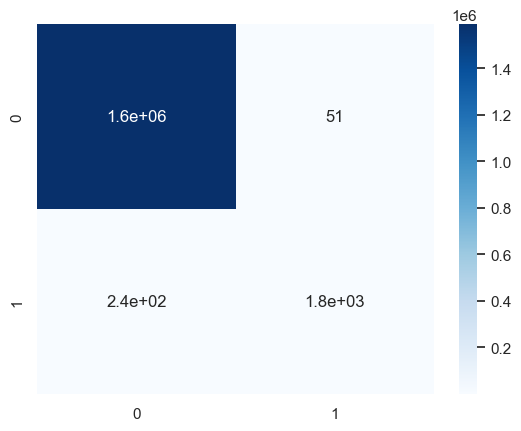

In [24]:
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, cmap="Blues")

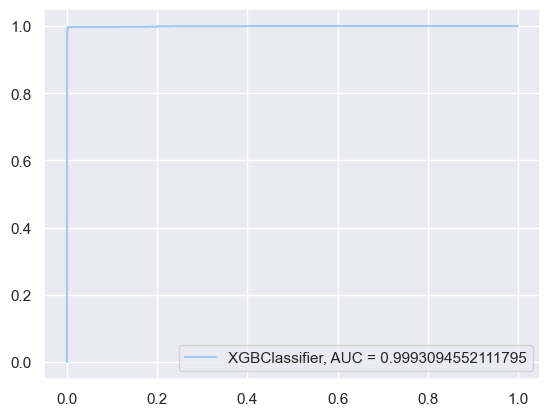

In [30]:
Y_pred_proba = xgbmodel.predict_proba(X_test)[::,1]
plot_roc_auc(Y_pred_proba, Y_test, "XGBClassifier")

### Random Forest Classifier

In [64]:
from sklearn.ensemble import RandomForestClassifier

In [65]:
rfcmodel = RandomForestClassifier(n_estimators=15, oob_score=True, class_weight='balanced', n_jobs=-1)
rfcmodel.fit(X_train, Y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=15, n_jobs=-1,
                       oob_score=True)

In [71]:
Y_pred = rfcmodel.predict(X_test)
Y_predtrain = rfcmodel.predict(X_train)
rfc_auprc = average_precision_score(Y_test, Y_pred)
print("The Area Under Precision Recall Curve is ", rfc_auprc)
print(classification_report(Y_test, Y_pred))

The Area Under Precision Recall Curve is  0.7617865605881046
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588610
           1       0.97      0.78      0.87      2045

    accuracy                           1.00   1590655
   macro avg       0.99      0.89      0.93   1590655
weighted avg       1.00      1.00      1.00   1590655



<Axes: >

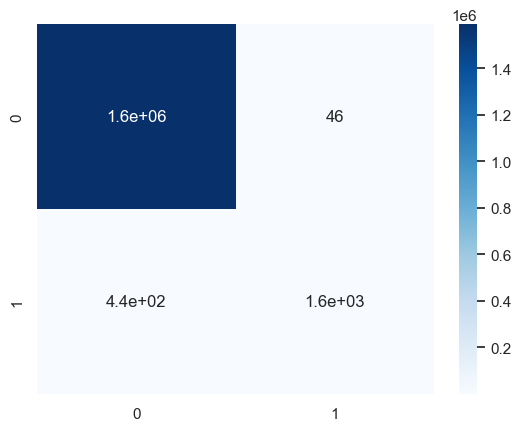

In [67]:
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, cmap="Blues")

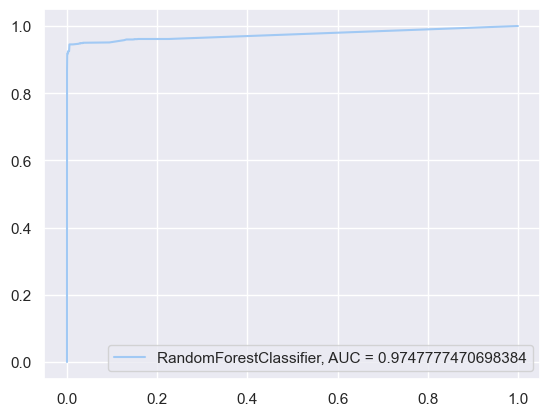

In [68]:
Y_pred_proba = rfcmodel.predict_proba(X_test)[::,1]
plot_roc_auc(Y_pred_proba, Y_test, "RandomForestClassifier")

В итоге, после обучения трех моделей: LinearRegressor, XGBoostClassifier и RandomForestClassifier, получили, что лучший перформанс по метрике AUPRC (для класса _1 - Fraud Transaction_) показывает _**XGBoostClassifier**_:

In [73]:
print("LinearRegressor:", lr_auprc)
print("XGBoostClassifier:", xgb_auprc)
print("RandomForestClassifier:", rfc_auprc)

LinearRegressor: 0.012687610217383637
XGBoostClassifier: 0.8590258741843402
RandomForestClassifier: 0.7617865605881046


Соответственно, для предсказания мошеннических транзакций желательно использовать именно XGBoostClassifier.

## Exporting Model

С помощью модуля pickle сериализуем и экспортируем в виде файла обученную XGBoost-модель.

In [26]:
import pickle

file = "xgb.pkl"
pickle.dump(xgbmodel, open(file, "wb"))